In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.model_selection import KFold, train_test_split, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor


sns.set_style("whitegrid")

In [2]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

In [3]:
data=pd.read_csv("../3. EDA and data preprocessing/preprocessed_training_data.csv")

# The Global mean baseline model

In [4]:
updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']

mae_results = {}
mae_results['Global_Mean'] = defaultdict(list)


for fold, (train_idx, test_idx) in enumerate(gkf.split(data, groups=data["participant_id"])):
  train, holdout=data.iloc[train_idx], data.iloc[test_idx]
  global_mean_preds = train[updrs_cols].mean().to_dict()

  holdout_preds_mean = holdout.copy()
  for col, mean_val in global_mean_preds.items():
    holdout_preds_mean[f'pred_{col}'] = mean_val

  for col in updrs_cols:
      actual_values = holdout_preds_mean[col]
      predicted_values = holdout_preds_mean[f'pred_{col}']

      valid_indices = predicted_values.notna()
      mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])
      mae_results['Global_Mean'][col].append(mae)

print("\n Cross Validation results for Global Mean")
for col, scores in mae_results['Global_Mean'].items():
    avg_mae = np.mean(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f}")
    mae_results['Global_Mean'][col]=avg_mae



 Cross Validation results for Global Mean
Average MAE for updrs_1: 4.3149
Average MAE for updrs_2: 5.2840
Average MAE for updrs_3: 11.7066


# Mean by Visit Month Baseline Model

In [5]:

mae_results['Mean_by_Visit_Month_Baseline_Model'] = defaultdict(list)


for fold, (train_idx, test_idx) in enumerate(gkf.split(data, groups=data["participant_id"])):
  train, holdout=data.iloc[train_idx], data.iloc[test_idx]
  mean_by_month = train.groupby('visit_month')[updrs_cols].mean()

  holdout_preds_mean = holdout.copy()
  test_preds_month_mean = holdout_preds_mean.merge(
      mean_by_month.rename(columns=lambda c: f'pred_{c}'),
      on='visit_month',
      how='left'
  )

  # Handle cases where a visit_month in the test set might not be in the train set
  # We'll fill any NaNs with the overall global mean

  for col in updrs_cols:
      test_preds_month_mean[f'pred_{col}']=test_preds_month_mean[f'pred_{col}'].fillna(global_mean_preds[col])

  for col in updrs_cols:
      actual_values = test_preds_month_mean[col]
      predicted_values = test_preds_month_mean[f'pred_{col}']

      valid_indices = predicted_values.notna()
      mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])
      mae_results['Mean_by_Visit_Month_Baseline_Model'][col].append(mae)


print("\n Cross Validation results for Mean by Visit Month Baseline Model")
for col, scores in mae_results['Mean_by_Visit_Month_Baseline_Model'].items():
    avg_mae = np.mean(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f}")
    mae_results['Mean_by_Visit_Month_Baseline_Model'][col]=avg_mae






 Cross Validation results for Mean by Visit Month Baseline Model
Average MAE for updrs_1: 4.2996
Average MAE for updrs_2: 5.2177
Average MAE for updrs_3: 11.5654


# Random Forest Model

In [7]:
initial_feature_cols=["age_at_baseline", "visit_month"]

mae_results['Random_Forest'] = defaultdict(list)


for fold, (train_idx, test_idx) in enumerate(gkf.split(data, groups=data["participant_id"])):
    train_fold = data.iloc[train_idx]
    holdout_fold = data.iloc[test_idx]



    X_train, y_train = train_fold[initial_feature_cols], train_fold[updrs_cols]
    X_holdout, y_holdout = holdout_fold[initial_feature_cols], holdout_fold[updrs_cols]
    y_train_clean = y_train.dropna()
    X_train_clean = X_train.loc[y_train_clean.index]

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model = MultiOutputRegressor(rf)

    model.fit(X_train_clean, y_train_clean)

    predictions_array = model.predict(X_holdout)

    predictions_df = pd.DataFrame(predictions_array, index=X_holdout.index, columns=updrs_cols)

    for col in updrs_cols:
        actual_values = y_holdout[col]
        predicted_values = predictions_df[col]

        valid_indices = actual_values.notna()
        mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])

        mae_results['Random_Forest'][col].append(mae)

print("\n--- Cross-Validation Results for Random Forest Baseline ---")

for col, scores in mae_results['Random_Forest'].items():
    avg_mae = np.mean(scores)
    std_mae = np.std(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f}")
    mae_results['Random_Forest'][col]=avg_mae


--- Cross-Validation Results for Random Forest Baseline ---
Average MAE for updrs_1: 4.3856
Average MAE for updrs_2: 5.3028
Average MAE for updrs_3: 11.6398


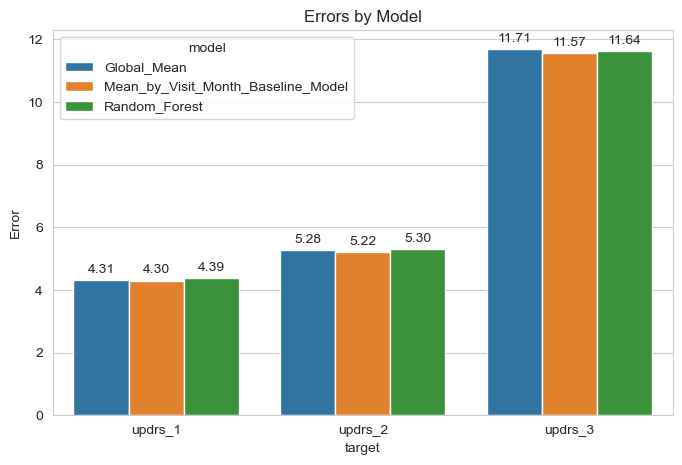

In [7]:
df = pd.DataFrame.from_dict(mae_results, orient='index')

df.to_csv("baseline_model_errors.csv", index_label='Model')

df = df.reset_index().rename(columns={'index': 'model'})

long_df = df.melt(id_vars='model', var_name='target', value_name='error').dropna()

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=long_df, x='target', y='error', hue='model')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)
plt.title('Errors by Model')
plt.ylabel('Error')
plt.show()

# Conclusion: 

Observe that the random forest model performs no better than the other two models, even if we select `visit_month` and `age_at_baseline`, which has the largest impacts on updrs scores progression by our preliminary EDA. This reveal the nature for predictions regrading the time series data, where the partcipant's own starting point and trajectory are the most important feature. Namely, the model needs to "memorize" past information in order to improve its performance on predicting the progression.

<br>

#### This also point the direction for our next step: to try the tree models with lags.